In [1]:
!wget https://clark.physics.illinois.edu/stats.py
import stats

--2024-03-04 11:09:53--  https://clark.physics.illinois.edu/stats.py
Resolving clark.physics.illinois.edu (clark.physics.illinois.edu)... 18.220.149.166
Connecting to clark.physics.illinois.edu (clark.physics.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1979 (1.9K)
Saving to: ‘stats.py.2’

stats.py.2          100%[===================>]   1.93K  --.-KB/s    in 0s      

2024-03-04 11:09:54 (377 MB/s) - ‘stats.py.2’ saved [1979/1979]



In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import random as rnd
from numba import jit
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from collections import defaultdict


In [3]:
# TESTING 1
@jit
def FlipSpin(x, y, matrix):
	if matrix[x][y] == 0:
		matrix[x][y] = 1
	else:
		matrix[x][y] = 0
	return matrix

@jit
def deltaE(x, y, matrix):
	dirs = [(-1, 0), (1, 0), (0, 1), (0, -1)]
	E = 0
	for coordPair in dirs:
		newX = (x + coordPair[0]) % len(matrix)
		newY = (y + coordPair[1]) % len(matrix[0])
		if matrix[x][y] == matrix[newX][newY]:
			E -= 2
		else:
			E += 2
	return E

@jit
def Energy(c, flipX, flipY, oldE):
	rows, cols = len(c), len(c[0])
	if oldE is not None:
		return oldE + deltaE(flipX, flipY, c)
	E = 0
	for row in range(rows):
		for col in range(cols):
			# right
			if col + 1 < cols:
				if c[row][col] == c[row][col + 1]:
					E += -1
				else:
					E += 1
			elif col == cols - 1:
				if c[row][col] == c[row][0]:
					E += -1
				else:
					E += 1
			# down
			if row + 1 < rows:
				if c[row][col] == c[row + 1][col]:
					E += -1
				else:
					E += 1
			elif row == rows - 1:
				if c[row][col] == c[0][col]:
					E += -1
				else:
					E += 1
	return E

In [4]:
@jit(nopython=True)
def binary_string_to_int(binary_str):
    result = 0
    for bit in binary_str:
        result = (result << 1) | (bit == '1')
    return result

def generateCombinations(currBinString, maxLen, combinations):
	if len(currBinString) == maxLen:
		combinations.append(currBinString.copy())
		return
	for bit in [0, 1]:
		currBinString.append(bit)
		generateCombinations(currBinString, maxLen, combinations)
		currBinString.pop()

def TheoreticalMCMC(n, temp):
	combinations = []
	generateCombinations([], n*n, combinations)
	configurations = []
	probabilities = []
	for combo in combinations:
		c = np.reshape(combo, (n, n))
		acceptProb = np.exp(-(1/temp) * Energy(c, None, None, None)) 
		binary_str = ''
		for spin in c.flatten():
			binary_str += '1' if spin else '0'
		convertedNum = binary_string_to_int(binary_str)
		configurations.append(convertedNum)
		probabilities.append(acceptProb)
	
	total_prob = np.sum(probabilities)
	normalized_probabilities = []
	for acceptProb in probabilities:
		normalized_probabilities.append(acceptProb / total_prob)
		
	return configurations, normalized_probabilities

In [6]:
@jit
def binary_string_to_int(binary_str):
    result = 0
    for bit in binary_str:
        result = (result << 1) | (bit == '1')
    return result

# Find the magnetization squared
	# take a final state
	# M = # of spin up - # spin down
	# N = # of spins(n*n)
	# M^2 = (M/N)^2
@jit
def magnetization_squared(finalConfigurationMatrix):
    count_ones = np.count_nonzero(finalConfigurationMatrix == 1)
    count_zeros = np.count_nonzero(finalConfigurationMatrix == 0)
    M = count_ones - count_zeros
    N = finalConfigurationMatrix.shape[0] * finalConfigurationMatrix.shape[1]
    return (M/N)**2

@jit
def MCMC(n, temp):
	c = np.ones((n, n))	
	e = Energy(c, None, None, None) # c, flipX, flipY, oldE
	energies = np.zeros(10000-20, dtype=np.int64)
	configurations = np.zeros(10000-20, dtype=np.int64)
	magnetizations_sqred = np.zeros(10000-20, dtype=np.float64)
	for sweep in range(10000):
		for i in range(n*n):
			flipX, flipY = np.random.randint(0, c.shape[0]), np.random.randint(0, c.shape[1])
			cP = FlipSpin(flipX, flipY, c.copy())
			eP = Energy(cP, flipX, flipY, e)
			r = np.random.rand()
			acceptProb = np.exp(-(eP - e)/temp)
			if acceptProb > r:
				c = cP
				e = eP
		if sweep >= 20:
			energies[sweep - 20] = e
			magnetizations_sqred[sweep - 20] = magnetization_squared(c)
			binary_str = ''
			for spin in c.flatten():
				if spin == 1:
					binary_str += '1'
				else:
					binary_str += '0'
			convertedNum = binary_string_to_int(binary_str)
			configurations[sweep - 20] = convertedNum
			
	return c, energies, magnetizations_sqred, configurations

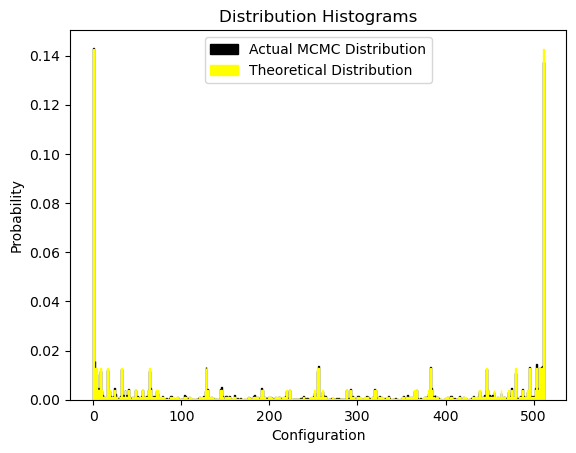

In [30]:
# MCMC = Calculated Distribution of Histogram found from MonteCarlo method, TheoreticalMCMC = Actual Real Distribution
temp = 1 / 0.3
finalMatrix, energies, magnetizations_sqred, configurations = MCMC(3, temp)
configurations1, normalized_probabilities = TheoreticalMCMC(3, temp)

# Get the normalized frequency = probability in this case for the unique configs for the MCMC
unique_configurations, configuration_counts = np.unique(configurations, return_counts=True)
probabilities = np.zeros(len(unique_configurations))
for i in range(len(unique_configurations)):
    probabilities[i] = configuration_counts[i] / len(configurations)

# Plot
plt.bar(unique_configurations, probabilities, width=1, color='black', edgecolor='black', label='Actual MCMC Distribution')
plt.bar(configurations1, normalized_probabilities, width=1, color='yellow', edgecolor='yellow', label='Theoretical Distribution')
plt.xlabel('Configuration')
plt.ylabel('Probability')
plt.title('Distribution Histograms')
plt.legend()

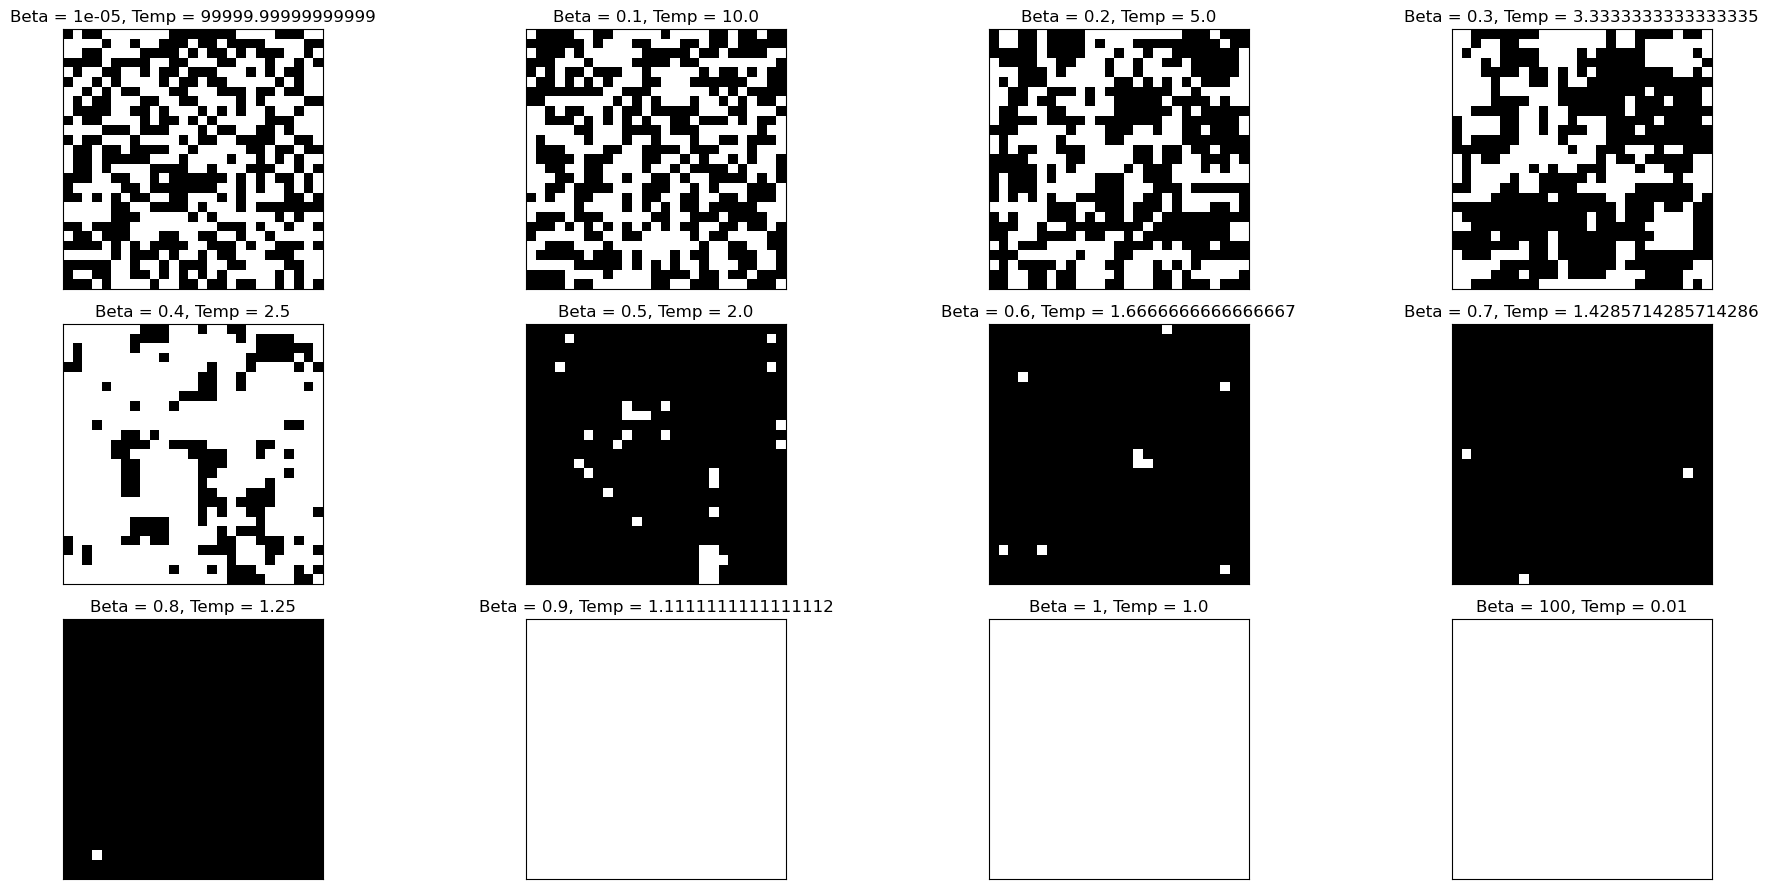

In [7]:
# 1. Generate Prototypical snapshots with pylab.matshow()
'''
    What I expect to see: At high betas = low temperatures so that means that we have more stable configurations so the matshows should be mostly the same color,
    if temp is high = beta is low so that means we will see more randomness in colors.
'''
betaVals = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
fig, axes = plt.subplots(3, 4, figsize=(20, 9))
for idx, beta in enumerate(betaVals):
      temp = 1 / beta
      finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
      ax = axes[idx // 4, idx % 4]
      ax.matshow(finalMatrix, cmap='binary') # 1 = white, 0 = black
      ax.set_title(f'Beta = {beta}, Temp = {temp}')
      ax.set_xticks([])
      ax.set_yticks([])
plt.tight_layout()
plt.show()

For 1e-05 theory_mean : 0.23607214428857715
For 1e-05 actual_mean : 0.45771543086172345
For 0.1 actual_mean : -147.9755511022044
For 0.2 actual_mean : -312.09018036072143
For 0.3 actual_mean : -514.0380761523046
For 0.4 actual_mean : -810.896993987976
For 0.5 actual_mean : -1274.9186372745492
For 0.6 actual_mean : -1391.6829659318637
For 0.7 actual_mean : -1431.6653306613227
For 0.8 actual_mean : -1446.9114228456913
For 0.9 actual_mean : -1453.2440881763528
For 1 actual_mean : -1455.9671342685372
For 100 theory_mean : -1458.0
For 100 actual_mean : -1458.0


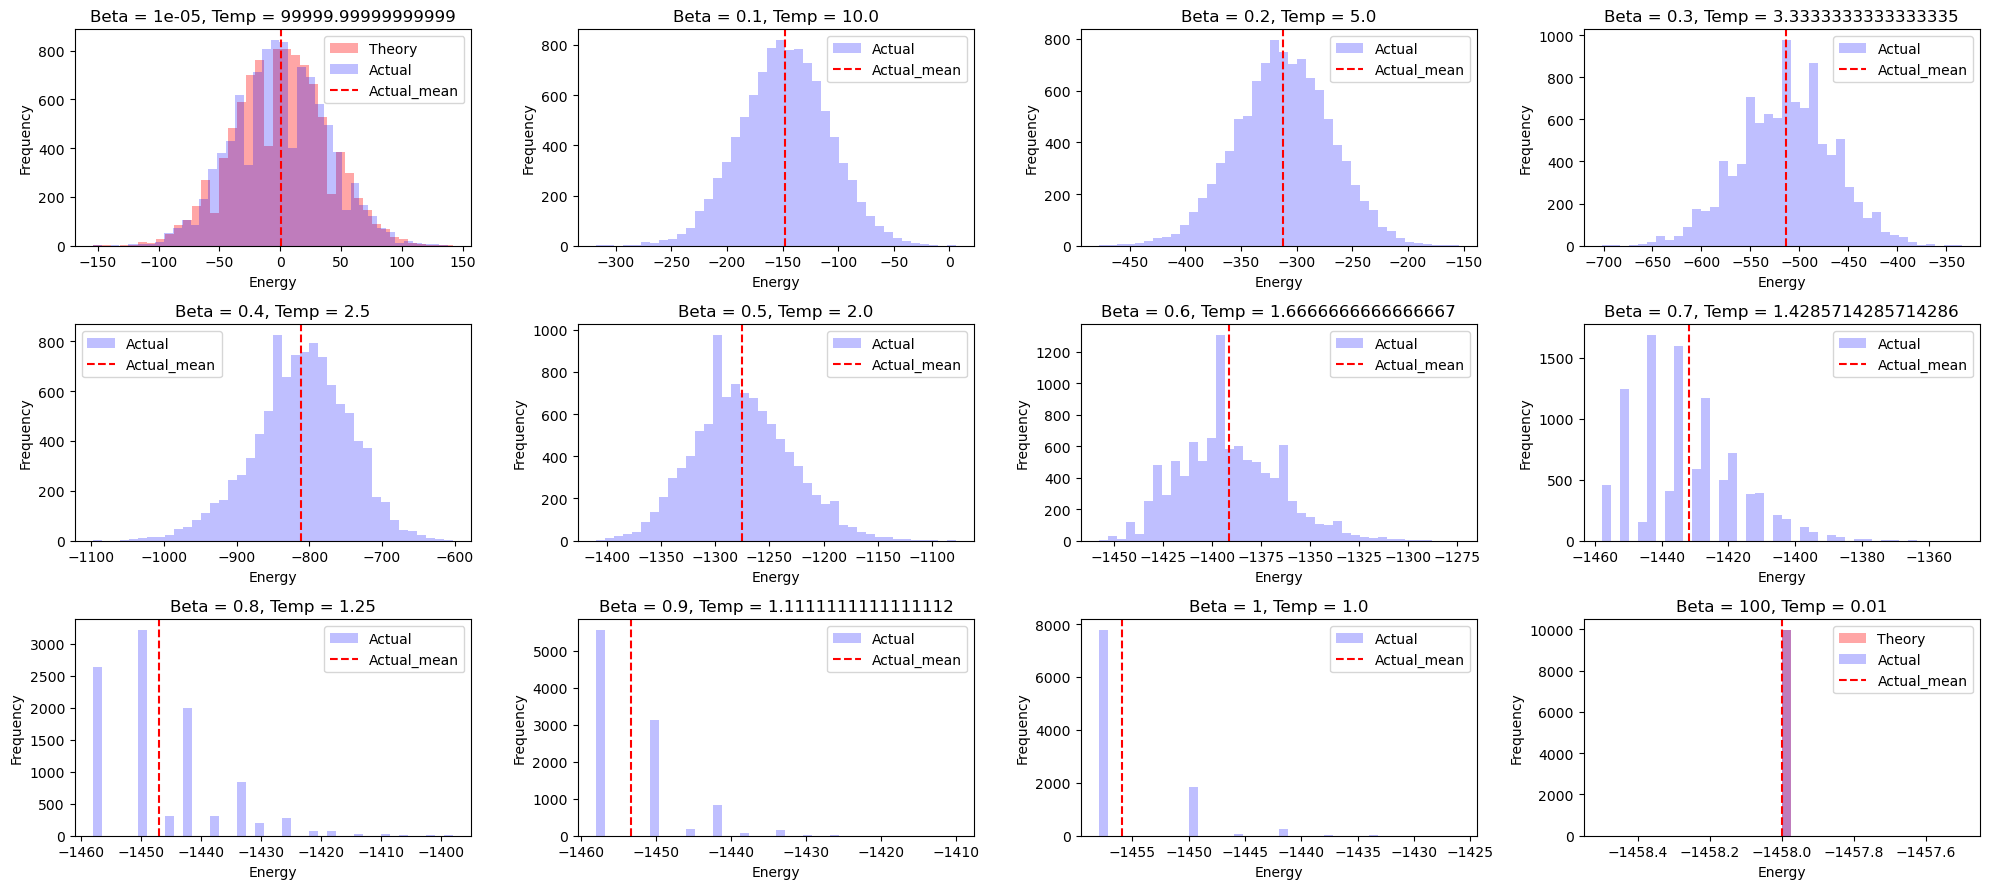

In [76]:
# #2. Generating a Histogram of P(E), Generating theory Histogram as well
# def TheoryCurve(n, temp):
# 	energies = np.zeros(10000-20, dtype=np.float64)
# 	magnetizations_sqred = np.zeros(10000-20, dtype=np.float64)
# 	for i in range(10000-20):
# 		c = np.random.choice([1, 0],(n,n))
# 		magnetizations_sqred[i] = magnetization_squared(c)
# 		energies[i] = np.exp(-(1/temp) * Energy(c, None, None, None)) 
# 	return energies, magnetizations_sqred

def TheoryCurve(n, beta):
	energies = np.zeros(10000-20, dtype=np.float64)
	magnetizations_sqred = np.zeros(10000-20, dtype=np.float64)
	for i in range(10000-20):
		if beta == 0.00001:
			c = np.random.choice([1, 0],(n,n))
			magnetizations_sqred[i] = magnetization_squared(c)
			energies[i] = Energy(c, None, None, None)
		elif beta == 100:
			randNum = np.random.choice([1, 0])
			c = np.random.choice([randNum], (n,n))
			magnetizations_sqred[i] = magnetization_squared(c)
			energies[i] = Energy(c, None, None, None)
	return energies, magnetizations_sqred

betaVals = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
plt.figure(figsize=(20, 9))
for idx, beta in enumerate(betaVals):
	temp = 1 / beta
	plt.subplot(3, 4, idx + 1)
	if beta == 0.00001 or beta == 100:
		energiesTheory, magnetizations_sqredTheory = TheoryCurve(27, beta)
		plt.hist(energiesTheory, bins=40, alpha=0.35, color='red', label="Theory")
		mean, variance, error, autocorrelation = stats.Stats(energiesTheory)
		print(f'For {beta} theory_mean : {mean}')
	finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
	mean, variance, error, autocorrelation = stats.Stats(energies)
	plt.hist(energies, bins=40, alpha=0.25, color='blue', label="Actual")
	plt.axvline(x=mean, color='r', linestyle='--', label=f'Actual_mean')
	print(f'For {beta} actual_mean : {mean}')
	plt.xlabel('Energy')
	plt.ylabel('Frequency')
	plt.title(f'Beta = {beta}, Temp = {temp}')
	plt.legend()
plt.tight_layout()
plt.show()

For 1e-05 theory_mean : 0.0013552497277046411
For 1e-05 actual_mean : 0.0013846747727250695
For 0.1 actual_mean : 0.0021001582874503127
For 0.2 actual_mean : 0.004011745446858726
For 0.3 actual_mean : 0.009146157873730378
For 0.4 actual_mean : 0.08387912941762805
For 0.5 actual_mean : 0.8335144362045495
For 0.6 actual_mean : 0.948220120197342
For 0.7 actual_mean : 0.9804785717045739
For 0.8 actual_mean : 0.9921406078823183
For 0.9 actual_mean : 0.9966110170480298
For 1 actual_mean : 0.998529250032144
For 100 theory_mean : 1.0
For 100 actual_mean : 1.0


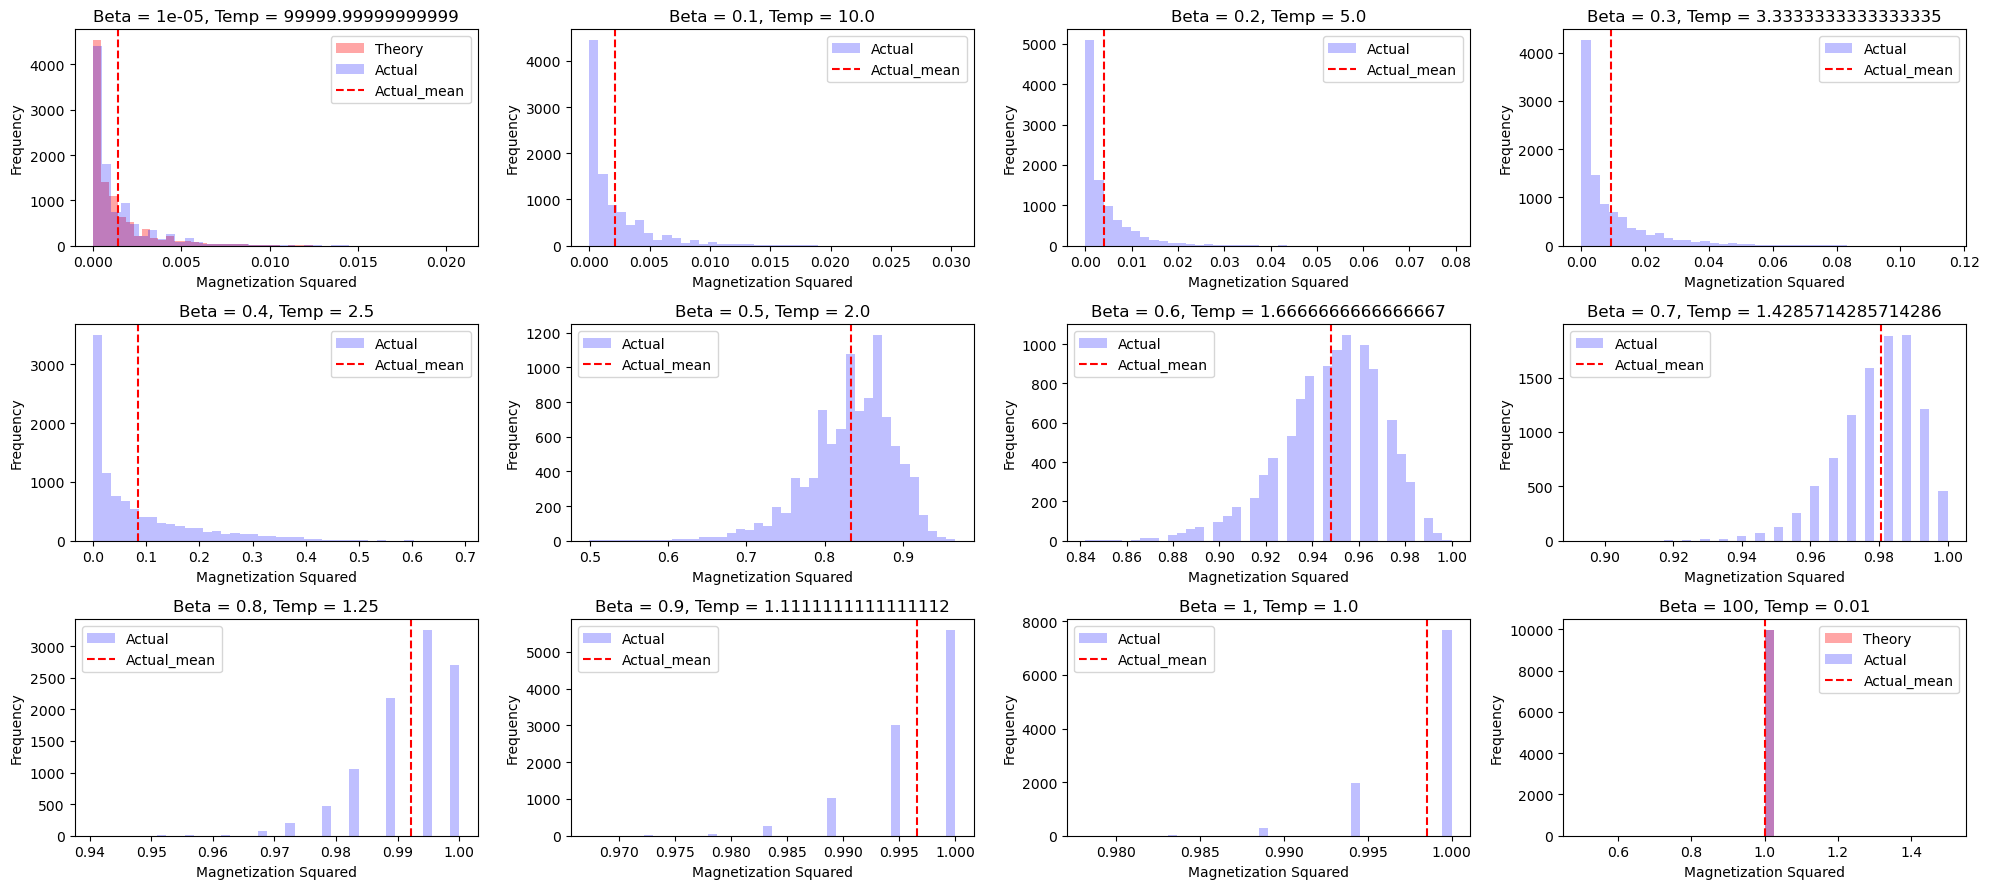

In [77]:
# Histogram of P(M^2)
betaVals = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 100]
plt.figure(figsize=(20, 9))
for idx, beta in enumerate(betaVals):
	temp = 1 / beta
	plt.subplot(3, 4, idx + 1)
	if beta == 0.00001 or beta == 100:
		energiesTheory, magnetizations_sqredTheory = TheoryCurve(27, beta)
		plt.hist(magnetizations_sqredTheory, bins=40, alpha=0.35, color='red', label="Theory")
		mean, variance, error, autocorrelation = stats.Stats(magnetizations_sqredTheory)
		print(f'For {beta} theory_mean : {mean}')
	finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
	mean, variance, error, autocorrelation = stats.Stats(magnetizations_sqred)
	plt.hist(magnetizations_sqred, bins=40, alpha=0.25, color='blue', label="Actual")
	plt.axvline(x=mean, color='r', linestyle='--', label=f'Actual_mean')
	print(f'For {beta} actual_mean : {mean}')
	plt.xlabel('Magnetization Squared')
	plt.ylabel('Frequency')
	plt.title(f'Beta = {beta}, Temp = {temp}')
	plt.legend()
plt.tight_layout()
plt.show()

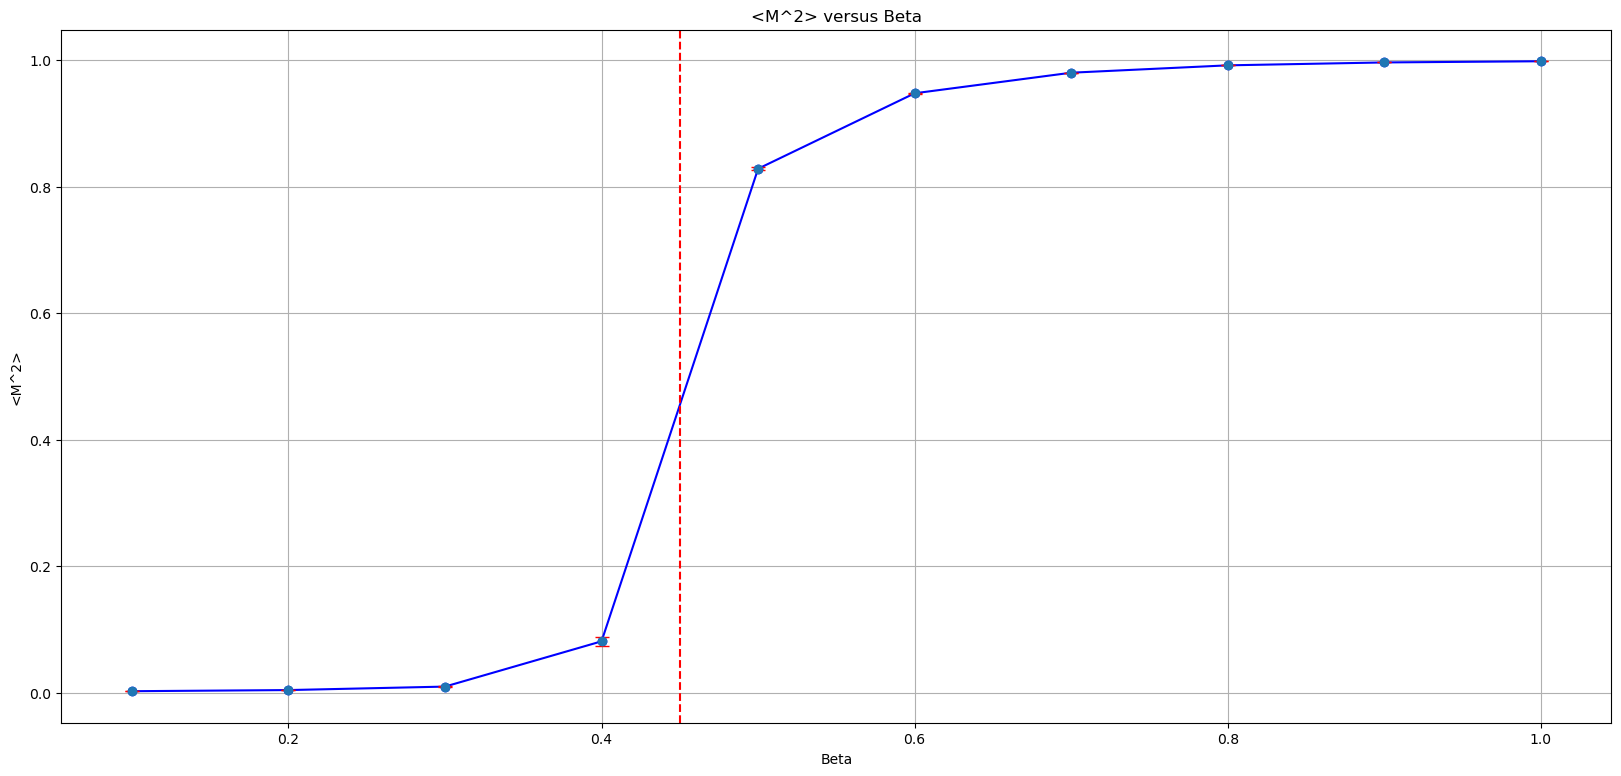

In [10]:
# Graph <M^2> as a function of Beta with the error bars as well
betaVals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mean_magnetizations_sq = []
errors = []

for beta in betaVals:
    temp = 1 / beta
    finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
    mean, variance, error, autocorrelation = stats.Stats(magnetizations_sqred)
    mean_magnetizations_sq.append(mean)
    errors.append(error)

betaVals = np.array(betaVals)
mean_magnetizations_sq = np.array(mean_magnetizations_sq)
errors = np.array(errors)

plt.figure(figsize=(20, 9))
plt.plot(betaVals, mean_magnetizations_sq, marker='o', linestyle='-', color='b')
plt.errorbar(betaVals, mean_magnetizations_sq, yerr=errors, fmt='o', ecolor='r', elinewidth=2, capsize=5)
plt.axvline(x=0.45, color='r', linestyle='--')
plt.xlabel('Beta')
plt.ylabel('<M^2>')
plt.title('<M^2> versus Beta')
plt.grid(True)
plt.show()

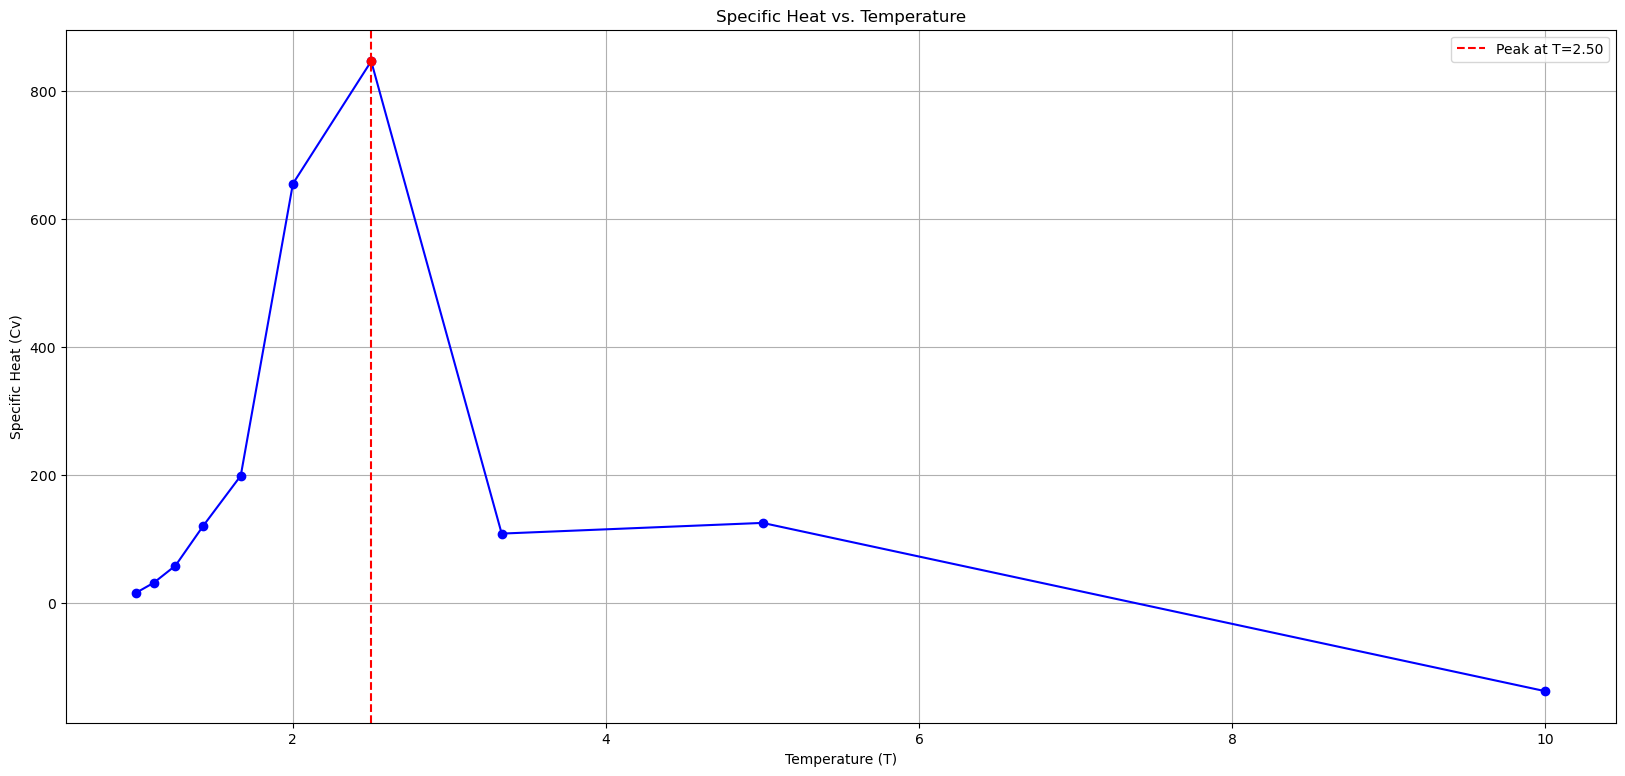

In [11]:
# Produce curve of the specific heat vs T.
betaVals = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
temperatures = []
average_energies = []
for beta in betaVals:
    temp = 1 / beta
    finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
    mean, variance, error, autocorrelation = stats.Stats(energies)
    average_energies.append(mean)
    temperatures.append(temp)

temperatures = np.array(temperatures)
average_energies = np.array(average_energies)

# spline to the average energy as a function of temperature, find spec_heat as delltemp of E
energy_spline = UnivariateSpline(temperatures, average_energies, s=0)
specific_heat = energy_spline.derivative()(temperatures)
max_idx = np.argmax(specific_heat)
peak_temperature = temperatures[max_idx]
peak_specific_heat = specific_heat[max_idx]

plt.figure(figsize=(20, 9))
plt.plot(temperatures, specific_heat, 'o-', color='blue')
plt.plot(peak_temperature, peak_specific_heat, 'ro')
plt.axvline(x=peak_temperature, color='red', linestyle='--', label=f'Peak at T={peak_temperature:.2f}')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat (Cv)')
plt.title('Specific Heat vs. Temperature')
plt.legend()
plt.grid(True)
plt.show()


Page 3: The Renormalization Group

In [10]:
@jit
def course_grain(c):
	n = c.shape[0] // 3
	newC = np.zeros((n, n), dtype=np.int64)
	for row in range(0, c.shape[0], 3):
		for col in range(0, c.shape[1], 3):
			# extract the 3x3 block
			currBlock = c[row:row+3, col:col+3]
			#flatten the block
			flat_block = currBlock.flatten()
			# count the ups and down,
			numOfUps = np.count_nonzero(flat_block == 1)
			numOfDowns = np.count_nonzero(flat_block == 0)
			# change the course grained matrix to account for the up or down
			newC[row // 3, col // 3] = 1 if numOfUps > numOfDowns else 0
	return newC


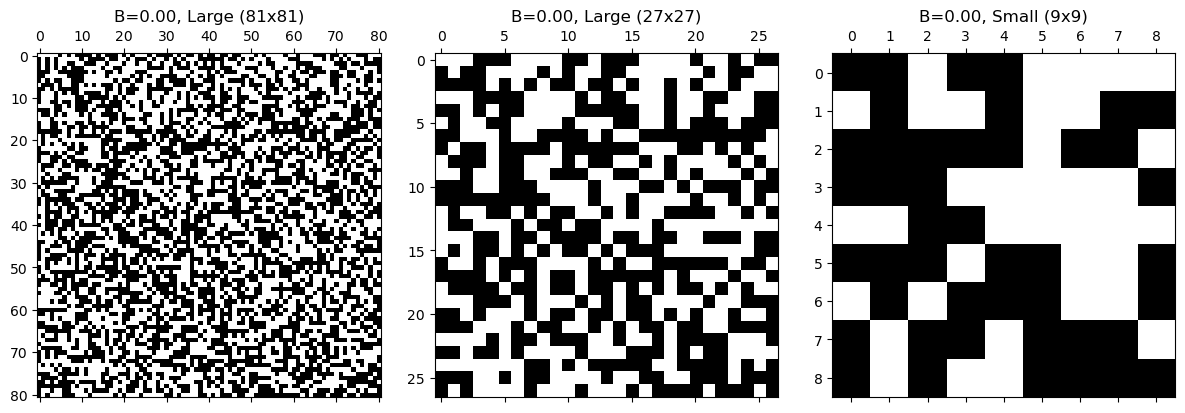

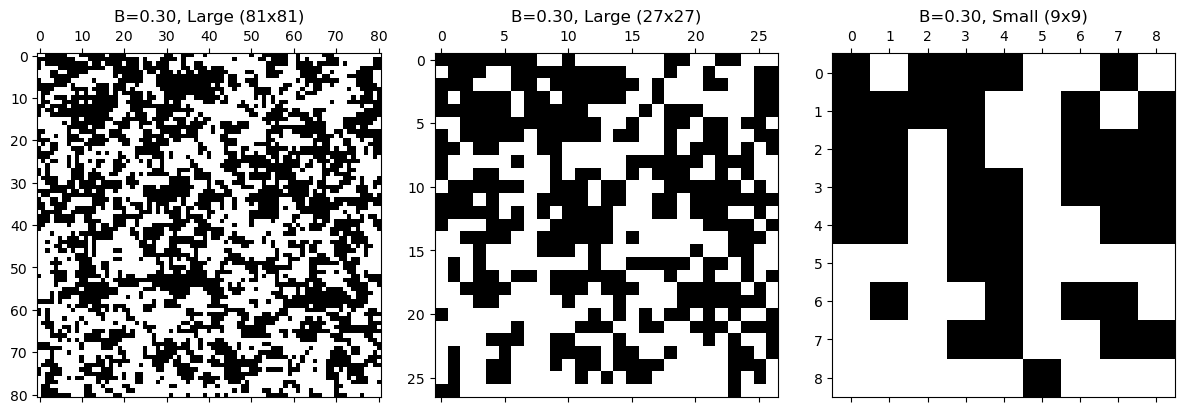

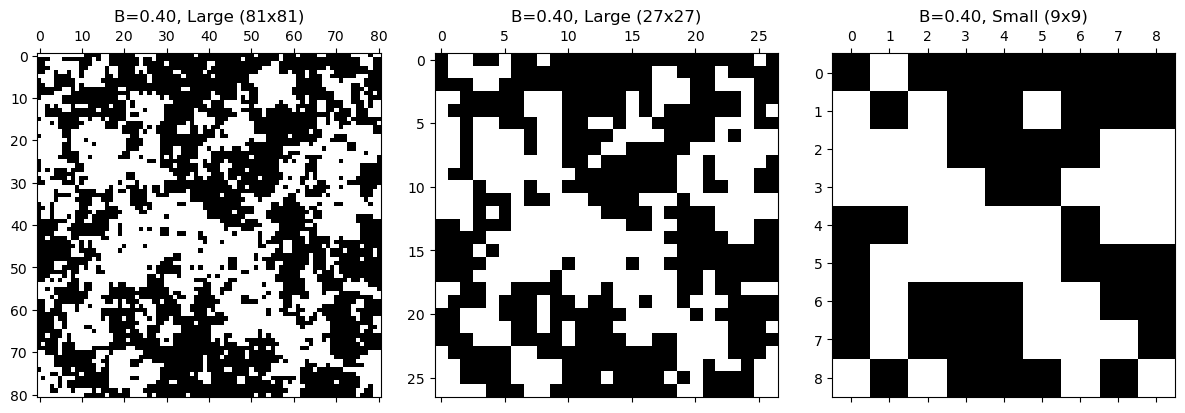

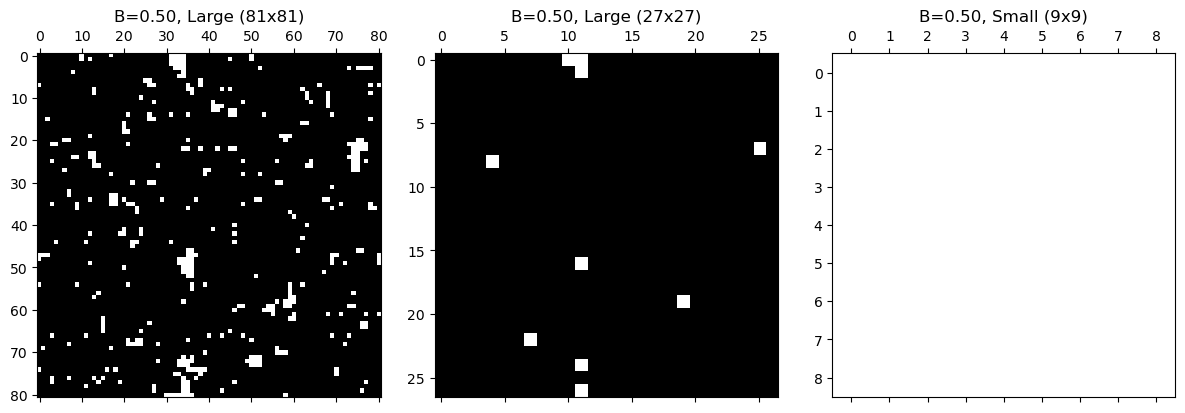

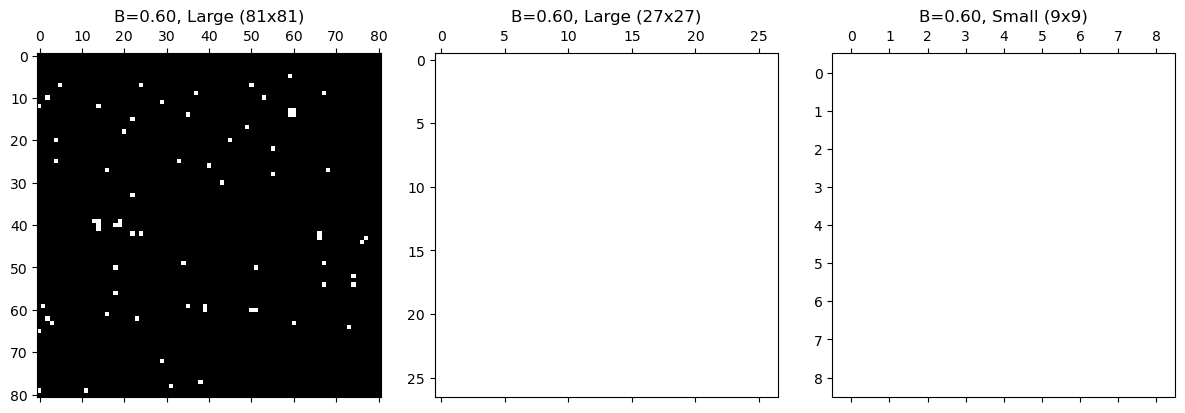

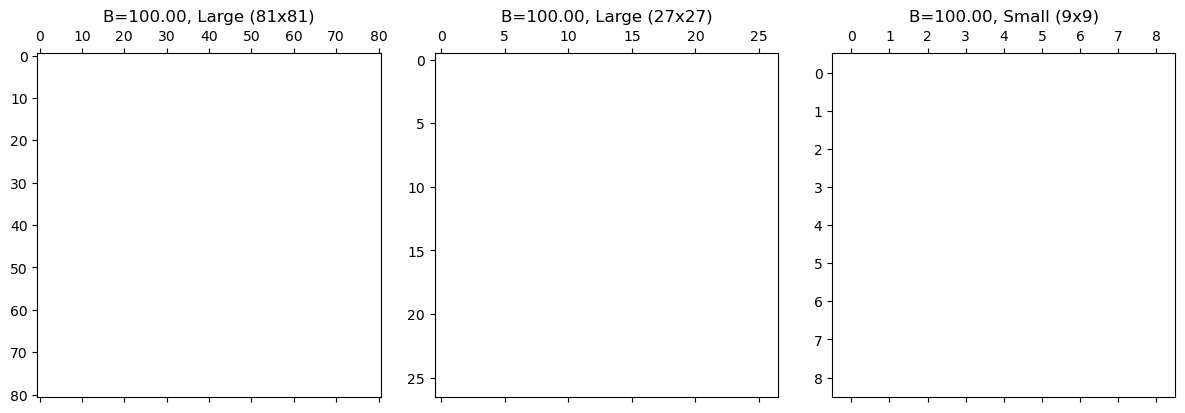

In [7]:
# Generate the Matshows for betavals and the coarsegrain for 81, 27, 9
betaVals = [0.00001, 0.3, 0.4, 0.5, 0.6, 100] # B = 0(I am using 0.00001), for B = inf(I am using 100)
for beta in betaVals:
	temp = 1 / beta
	finalMatrix, energies, magnetizations_sqred, configurations = MCMC(81, temp)
	mediumMatrix = course_grain(finalMatrix.copy())
	smallMatrix = course_grain(mediumMatrix.copy())
	fig, axes = plt.subplots(1, 3, figsize=(12, 4))
	axes[0].matshow(finalMatrix, cmap='binary')
	axes[0].set_title(f'B={beta:.2f}, Large (81x81)')
	axes[1].matshow(mediumMatrix, cmap='binary')
	axes[1].set_title(f'B={beta:.2f}, Large (27x27)')
	axes[2].matshow(smallMatrix, cmap='binary')
	axes[2].set_title(f'B={beta:.2f}, Small (9x9)')
	plt.tight_layout()
	plt.show()

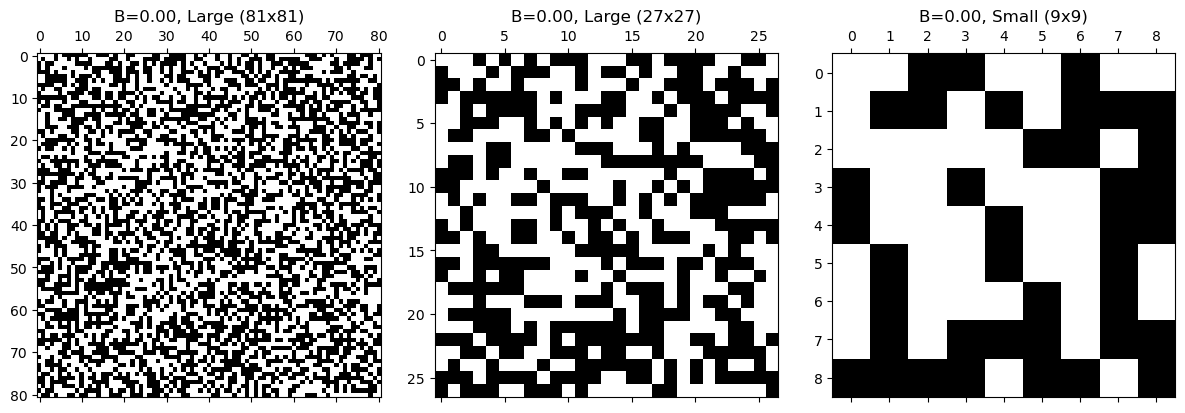

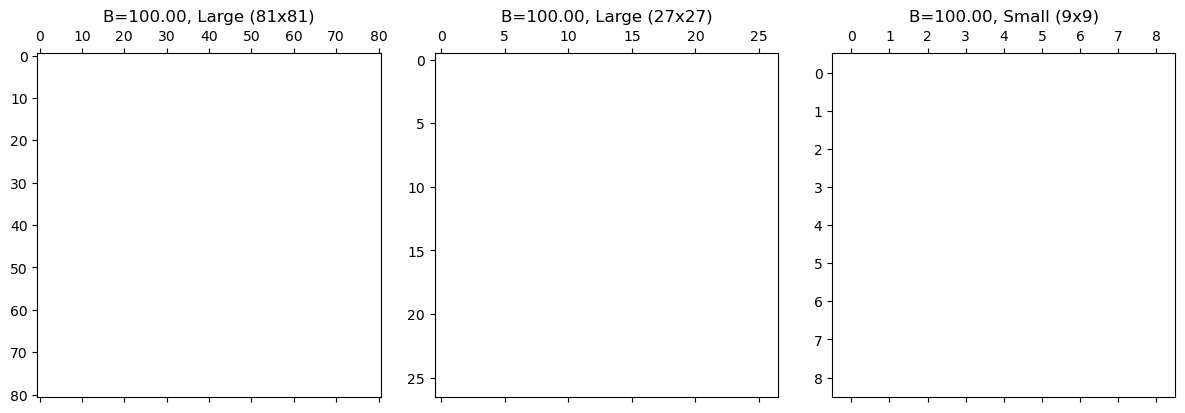

In [25]:
# Generate the Matshows for betavals and the coarsegrain for 81, 27, 9 for Theory betas 0.00001 and 100
betaVals = [0.00001, 100] # B = 0(I am using 0.00001), for B = inf(I am using 100)
for beta in betaVals:
	temp = 1 / beta
	fig, axes = plt.subplots(1, 3, figsize=(12, 4))
	if beta == 0.00001:
		c = np.random.choice([1, 0],(81, 81))
		mediumMatrix = course_grain(c.copy())
		smallMatrix = course_grain(mediumMatrix.copy())
		axes[0].matshow(c, cmap='binary')
		axes[0].set_title(f'B={beta:.2f}, Large (81x81)')
		axes[1].matshow(mediumMatrix, cmap='binary')
		axes[1].set_title(f'B={beta:.2f}, Large (27x27)')
		axes[2].matshow(smallMatrix, cmap='binary')
		axes[2].set_title(f'B={beta:.2f}, Small (9x9)')
	if beta == 100:
		randNum = np.random.choice([1, 0])
		c = np.random.choice([randNum], (81, 81))
		mediumMatrix = course_grain(c.copy())
		smallMatrix = course_grain(mediumMatrix.copy())
		axes[0].matshow(c, cmap='binary')
		axes[0].set_title(f'B={beta:.2f}, Large (81x81)')
		axes[1].matshow(mediumMatrix, cmap='binary')
		axes[1].set_title(f'B={beta:.2f}, Large (27x27)')
		axes[2].matshow(smallMatrix, cmap='binary')
		axes[2].set_title(f'B={beta:.2f}, Small (9x9)')
	plt.tight_layout()
	plt.show()

In [8]:
# Native 27x27 below
betaVals = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # B = 0(I am using 0.00001), for B = inf(I am using 100)
mean_magnetizations_sq = []
for beta in betaVals:
    temp = 1 / beta
    finalMatrix, energies, magnetizations_sqred, configurations = MCMC(27, temp)
    mean, variance, error, autocorrelation = stats.Stats(magnetizations_sqred)
    mean_magnetizations_sq.append(mean)

In [11]:
@jit(nopython=True)
def coursegrained_MCMC(n, temp):
	c = np.ones((n, n))	
	e = Energy(c, None, None, None) # c, flipX, flipY, oldE
	energies = np.zeros(10000-20, dtype=np.int64)
	configurations = np.zeros(10000-20, dtype=np.int64)
	magnetizations_sqred = np.zeros(10000-20, dtype=np.float64)
	for sweep in range(10000):
		for i in range(n*n):
			flipX, flipY = np.random.randint(0, c.shape[0]), np.random.randint(0, c.shape[1])
			cP = FlipSpin(flipX, flipY, c.copy())
			eP = Energy(cP, flipX, flipY, e)
			r = np.random.rand()
			acceptProb = np.exp(-(eP - e)/temp)
			if acceptProb > r:
				c = cP
				e = eP
		if sweep >= 20:
			energies[sweep - 20] = e
			config_to_coarse = c.copy()
			mediumMatrix = course_grain(config_to_coarse)
			magnetizations_sqred[sweep-20] = magnetization_squared(mediumMatrix)
			binary_str = ''
			for spin in c.flatten():
				if spin == 1:
					binary_str += '1'
				else:
					binary_str += '0'
			convertedNum = binary_string_to_int(binary_str)
			configurations[sweep - 20] = convertedNum
			
	return c, energies, magnetizations_sqred, configurations

# Doing the course grain of the 27x27 below
betaVals = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # B = 0(I am using 0.00001), for B = inf(I am using 100)
mean_magnetizations_sq_coarse = []
for beta in betaVals:
    temp = 1 / beta
    # coursegrained_MCMC, takes the 81x81, but then at each sweep course_grain
    # get the M^2, and put it in the magnetizations_sqred
    # so in the line below the magnetization_sqred will have the M^2 of the coursegrained version of the 81x81
    finalMatrix, energies, magnetizations_sqred, configurations = coursegrained_MCMC(81, temp)
    mean, variance, error, autocorrelation = stats.Stats(magnetizations_sqred)
    mean_magnetizations_sq_coarse.append(mean)

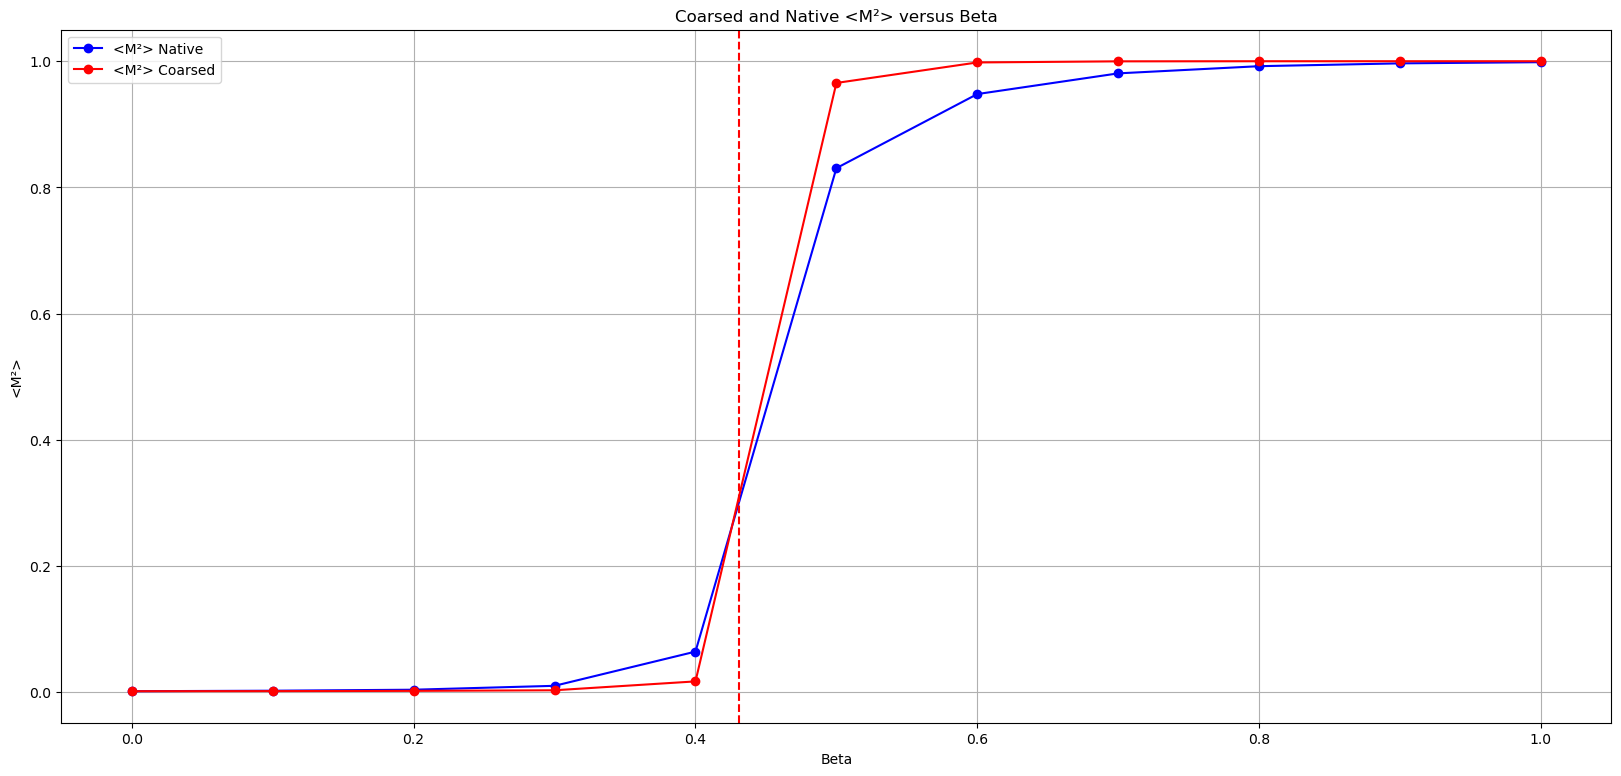

In [12]:
# Graph Coarsed and Native <M^2> as a function of Beta
betaVals = np.array(betaVals)
mean_magnetizations_sq = np.array(mean_magnetizations_sq)
mean_magnetizations_sq_coarse = np.array(mean_magnetizations_sq_coarse)

plt.figure(figsize=(20, 9))
plt.plot(betaVals, mean_magnetizations_sq, marker='o', linestyle='-', color='b', label='<M²> Native')
plt.plot(betaVals, mean_magnetizations_sq_coarse, marker='o', linestyle='-', color='r', label='<M²> Coarsed')
plt.axvline(x=0.431, color='r', linestyle='--')
plt.xlabel('Beta')
plt.ylabel('<M²>')
plt.title('Coarsed and Native <M²> versus Beta')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
def findInterval(J, betaVals):
	start = 0
	for end in range(1, len(betaVals)):
		if J >= betaVals[start] and J <= betaVals[end]:
			return betaVals[start], betaVals[end]
		else:
			start += 1
			end += 1
	return None, None

def findIntersectingPoint(x1, y1, x2, y2, J):
	slope = (y2 - y1) / (x2 - x1)
	y3 = y1 + slope * (J - x1)
	return J, y3

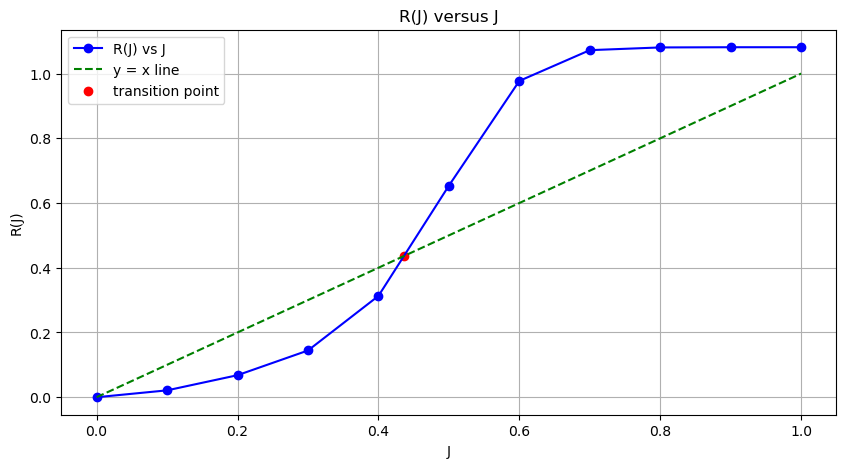

In [14]:
'''
Take the Native Curve <M^2> vs B
	1. Interpolate this using scipy.interpolate.interp1d
	2. Interpolation takes <M^2> and B vals of the native curve and use this to find the c
'''
interp_function = interp1d(mean_magnetizations_sq, betaVals, fill_value='extrapolate')
coarse_grained_betaVals = interp_function(mean_magnetizations_sq_coarse)

myMap = defaultdict(float)
for i, val in enumerate(betaVals):
	myMap[val] = coarse_grained_betaVals[i]

# find the intersection point in the middle
y1, y2 = myMap[0.4], myMap[0.5]
# Calculate slope of the line segment
slope = (y2 - y1) / (0.5 - 0.4)
 # Calculate y-intercept of the line segment
y_intercept = y1 - slope * 0.4
# Calculate x-coordinate of intersection point
x_intersect = y_intercept / (1 - slope)
# Calculate y-coordinate of intersection point
y_intersect = x_intersect

plt.figure(figsize=(10, 5))
plt.plot(betaVals, coarse_grained_betaVals, marker='o', linestyle='-', color='b', label='R(J) vs J')
plt.plot(betaVals, betaVals, linestyle='--', color='g', label='y = x line')
plt.scatter(x_intersect, y_intersect, color='red', label='transition point')
plt.xlabel('J')
plt.ylabel('R(J)')
plt.title('R(J) versus J')
plt.legend()
plt.grid(True)
plt.show()




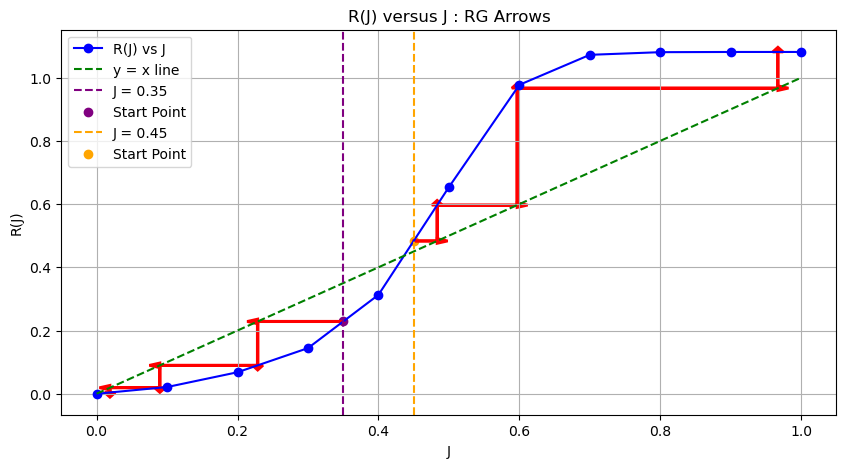

In [15]:
interp_function = interp1d(mean_magnetizations_sq, betaVals, kind='linear', fill_value='extrapolate')
coarse_grained_betaVals = interp_function(mean_magnetizations_sq_coarse)

plt.figure(figsize=(10, 5))
plt.plot(betaVals, coarse_grained_betaVals, marker='o', linestyle='-', color='b', label='R(J) vs J')
plt.plot(betaVals, betaVals, linestyle='--', color='g', label='y = x line')


J = 0.35
plt.axvline(J, linestyle='--', color='purple', label=f'J = {J}')
x1, x2 = findInterval(J, betaVals)
y1, y2 = myMap[x1], myMap[x2]
purpleX, purpleY = findIntersectingPoint(x1, y1, x2, y2, J)
plt.scatter(purpleX, purpleY, color='purple', label='Start Point')
for i in range(3):
	x1, x2 = findInterval(J, betaVals)
	if x1 == None or x2 == None:
		break
	y1, y2 = myMap[x1], myMap[x2]
	redX, redY = findIntersectingPoint(x1, y1, x2, y2, J)
	plt.arrow(redX, redY, redY - redX, redY - redY, color='red', head_width=0.015, head_length=0.015, linewidth=2)
	oldRedX, oldRedY = redX, redY
	J = redY
	x1, x2 = findInterval(J, betaVals)
	if x1 == None or x2 == None:
		break
	y1, y2 = myMap[x1], myMap[x2]
	redX, redY = findIntersectingPoint(x1, y1, x2, y2, J)
	plt.arrow(redX, oldRedY, redX - redX, redY - oldRedY, color='red', head_width=0.015, head_length=0.015, linewidth=2)

J = 0.45
plt.axvline(J, linestyle='--', color='orange', label=f'J = {J}')
x1, x2 = findInterval(J, betaVals)
y1, y2 = myMap[x1], myMap[x2]
orangeX, orangeY = findIntersectingPoint(x1, y1, x2, y2, J)
plt.scatter(orangeX, orangeY, color='orange', label='Start Point')
for i in range(3):
	x1, x2 = findInterval(J, betaVals)
	if x1 == None or x2 == None:
		break
	y1, y2 = myMap[x1], myMap[x2]
	redX, redY = findIntersectingPoint(x1, y1, x2, y2, J)
	plt.arrow(redX, redY, redY - redX, redY - redY, color='red', head_width=0.015, head_length=0.015, linewidth=2)
	oldRedX, oldRedY = redX, redY
	J = redY
	x1, x2 = findInterval(J, betaVals)
	if x1 == None or x2 == None:
		break
	y1, y2 = myMap[x1], myMap[x2]
	redX, redY = findIntersectingPoint(x1, y1, x2, y2, J)
	plt.arrow(redX, oldRedY, redX - redX, redY - oldRedY, color='red', head_width=0.015, head_length=0.015, linewidth=2)

plt.xlabel('J')
plt.ylabel('R(J)')
plt.title('R(J) versus J : RG Arrows')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
y1, y2 = myMap[0.4], myMap[0.5]
slope = (y2 - y1) / (0.5 - 0.4)
b = 3
criticalExponent = np.log(b) / np.log(slope)
print("The critical exponent is:", criticalExponent)

The critical exponent is: 0.8960194467728456
